# Setup environment

In [3]:
%matplotlib inline

In [4]:
# In case of plotly not showing the charts run!
import plotly.io as pio
pio.renderers.default='notebook'

## Functions

In [5]:
import numpy as np
import pandas as pd
from pysurvival.utils.metrics import concordance_index
from pysurvival.utils.display import integrated_brier_score
from sksurv.metrics import cumulative_dynamic_auc

def evaluate_model(model,X_train,T_train, E_train,X_test,T_test,E_test,
                   c_index=True,ibs=True,c_auc=True):

    # c-index
    if c_index:
        from pysurvival.utils.metrics import concordance_index
        c_index = concordance_index(model, X_test, T_test, E_test)
        print('c-index: {0:5.4f}'.format(c_index))
    else:
        c_index=0

    # ibs
    if ibs:        
        from pysurvival.utils.display import integrated_brier_score
        ibs = integrated_brier_score(model, X_test, T_test, E_test, t_max=200,
                    figure_size=(20, 6.5) )
        print('IBS: {0:5.4f}'.format(ibs))
    else:
        ibs=0

    # cumulative_auc
    if c_auc:
        from sksurv.metrics import cumulative_dynamic_auc

        train = np.array([(e,t) for e,t in zip(E_train,T_train)],dtype=[('event', 'bool_'),('time','int_')])
        test = np.array([(e,t) for e,t in zip(E_test,T_test)],dtype=[('event', 'bool_'),('time','int_')])

        # auc does not support inf risk so we replace with a really large value
        risk = model.predict_risk(X_test)
        risk = np.where(risk == np.inf,100,risk)

        auc_time_list,mean_auc = cumulative_dynamic_auc(train, test, risk, [100,300,500], tied_tol=1e-08)
        print('AUC: {0:5.4f}'.format(mean_auc))
    else:
        mean_auc=0

    #return results
    results = pd.DataFrame({'c_index':[c_index],
                                'ibs':[ibs],
                                'mean_auc':[mean_auc]})
    return results

# Load Data

In [2]:
import pandas as pd

# Get train data - full
X_train= pd.read_csv('data/X_train_20200206.csv')

T_train= pd.read_csv('data/T_train_20200206.csv',names=['time'])
T_train = T_train['time']

E_train= pd.read_csv('data/E_train_20200206.csv',names=['event'])
E_train = E_train['event']

# Get train data - fraq - only for metrics
X_train_f = X_train.sample(frac=0.5, random_state = 2020)
T_train_f = T_train.sample(frac=0.5, random_state = 2020)
E_train_f = E_train.sample(frac=0.5, random_state = 2020)

# Get test data
X_test= pd.read_csv('data/X_test_20200206.csv')

T_test= pd.read_csv('data/T_test_20200206.csv',names=['time'])
T_test = T_test['time']

E_test= pd.read_csv('data/E_test_20200206.csv',names=['event'])
E_test = E_test['event']

# Get Evaluation data
X_eval= pd.read_csv('data/X_eval_20200206.csv')
# X_eval = X_eval.sample(frac=0.2, random_state = 2020)

T_eval= pd.read_csv('data/T_eval_20200206.csv',names=['time'])
# T_eval = T_eval.sample(frac=0.2, random_state = 2020)
T_eval = T_eval['time']

E_eval= pd.read_csv('data/E_eval_20200206.csv',names=['event'])
# E_eval = E_eval.sample(frac=0.2, random_state = 2020)
E_eval = E_eval['event']

# Load model

In [4]:
# load model
from pysurvival.utils import load_model
model = load_model('model/churn_model_20200303.zip')

Loading the model from model/churn_model_20200303.zip


# Evaluate model

In [8]:
import pandas as pd

results = pd.DataFrame()

## Train data

c-index: 0.7515


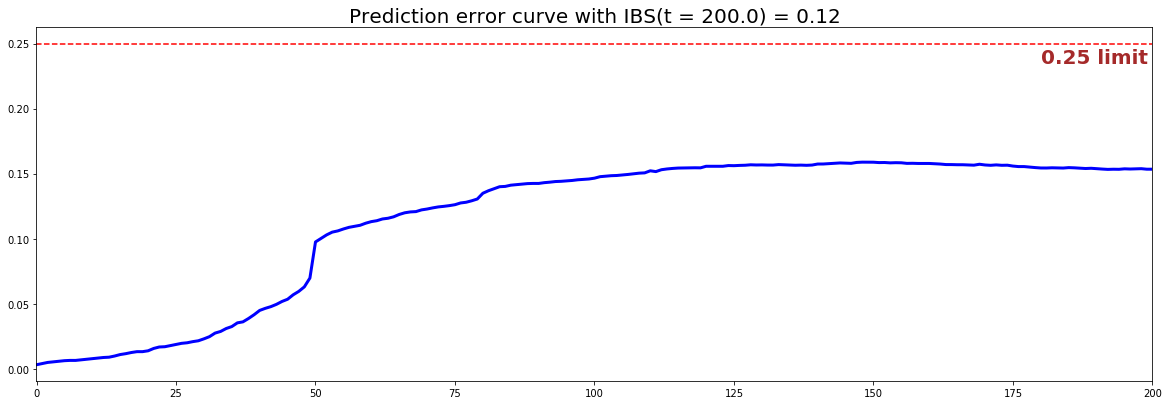

IBS: 0.1158
AUC: 0.8448


In [25]:
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_train_f,T_train_f,E_train_f)
tmp_results['data'] = 'train'
results = pd.concat([results,tmp_results])

## Test data

c-index: 0.7531


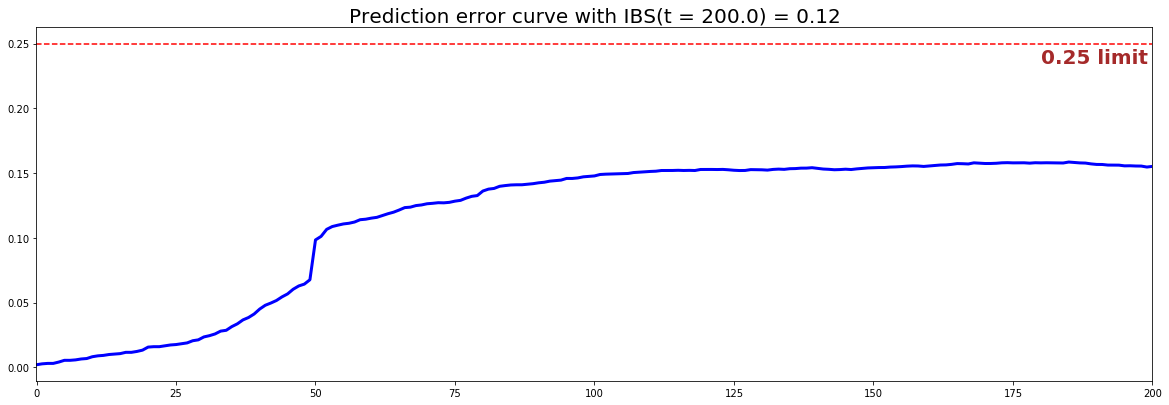

IBS: 0.1157
AUC: 0.8481


In [27]:
tmp_results = evaluate_model(model,X_train,T_train,E_train,X_test,T_test,E_test)
tmp_results['data'] = 'test'
results = pd.concat([results,tmp_results])

## Evaluation data

start:0 - end:5248
c-index: 0.7469


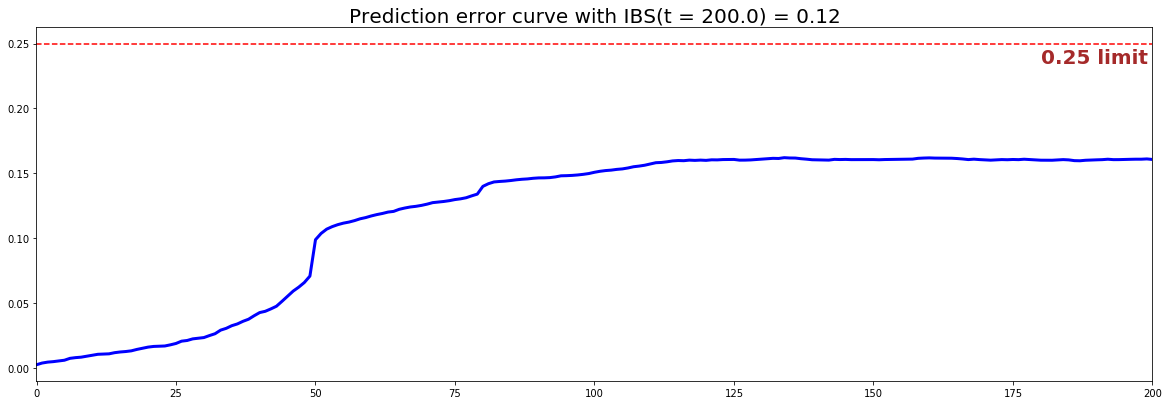

IBS: 0.1193
AUC: 0.8351
start:5249 - end:10496
c-index: 0.7477


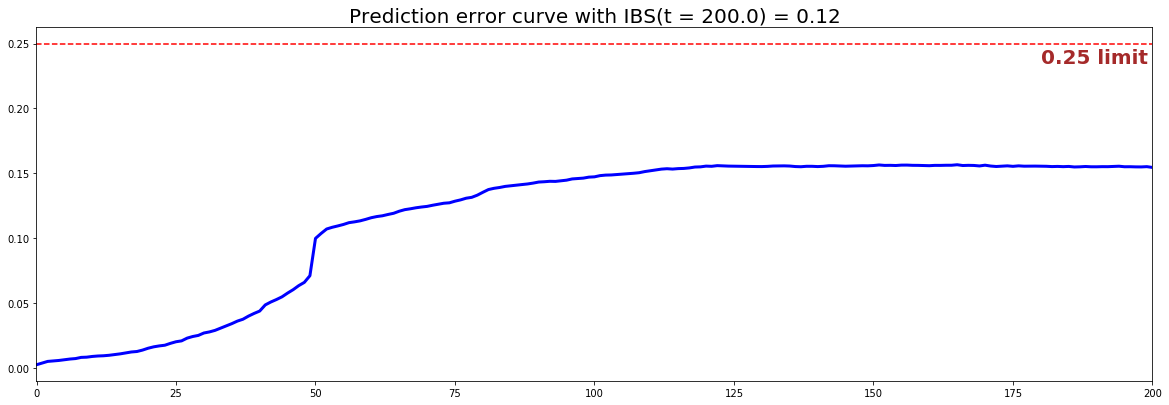

IBS: 0.1164
AUC: 0.8403
start:10497 - end:15744
c-index: 0.7602


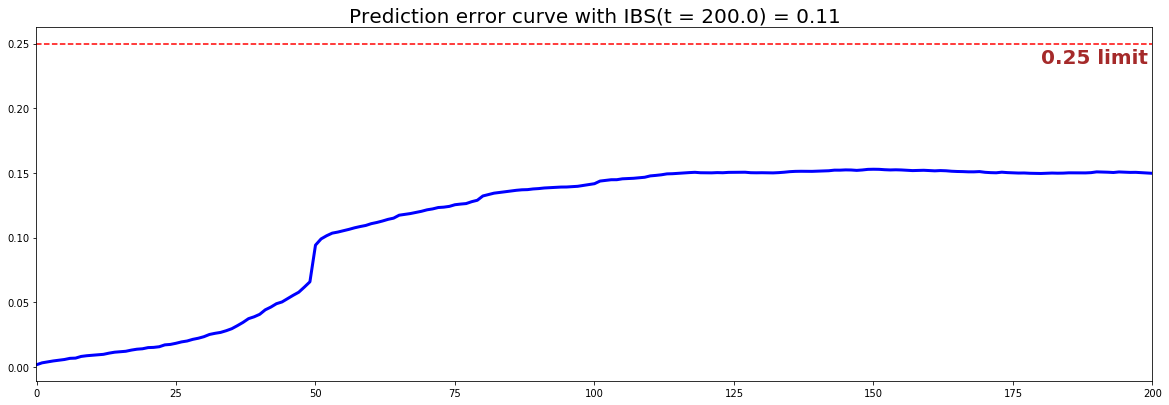

IBS: 0.1123
AUC: 0.8489
start:15745 - end:20992
c-index: 0.7476


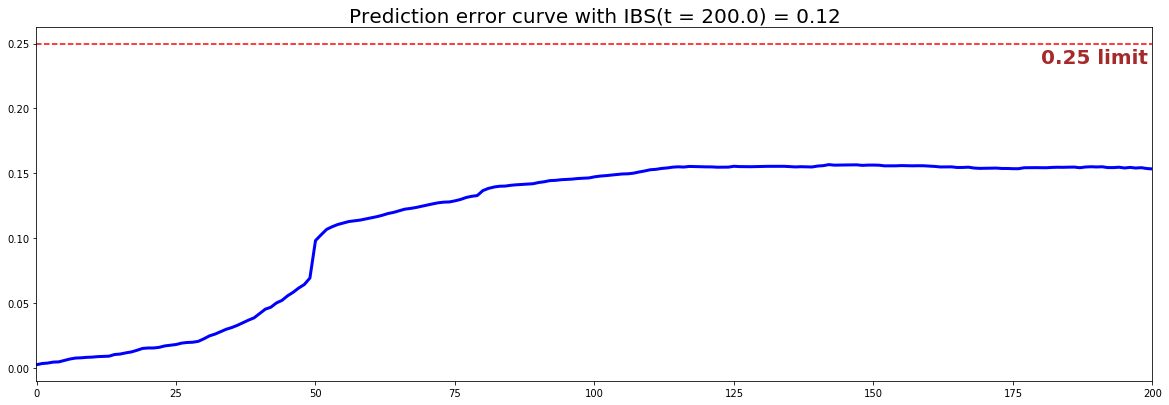

IBS: 0.1157
AUC: 0.8398
start:20993 - end:26238
c-index: 0.7467


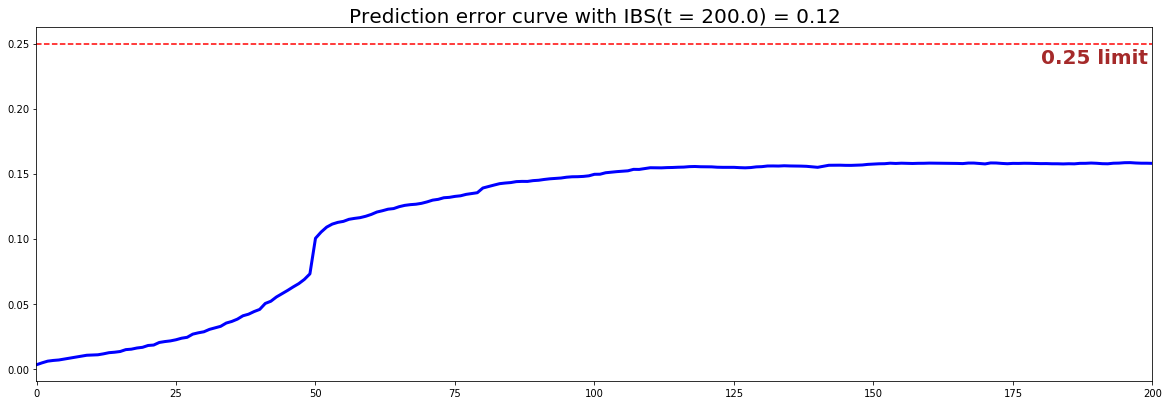

IBS: 0.1183
AUC: 0.8411


In [24]:
group_size = int(round(len(X_eval)/5,0))

for group in [0,1,2,3,4]:
    
    if group == 0:
        start_index = group * group_size 
    else:
        start_index = group * group_size + 1 
    
    if group == 4:
        end_index = len(X_eval) - 1
    else:
        end_index = (group + 1) * group_size
    
    print('start:{0} - end:{1}'.format(start_index, end_index))
    
    tmp_results = evaluate_model(model,X_train,T_train,E_train,X_eval[start_index:end_index],
                                 T_eval[start_index:end_index],E_eval[start_index:end_index])
    tmp_results['data'] = 'eval_group_{0}'.format(group)
    results = pd.concat([results,tmp_results])    

## Compare results

In [35]:
tmp_results = pd.DataFrame({'c_index':[results[0:5].mean()['c_index']],
                            'ibs':results[0:5].mean()['ibs'],
                            'mean_auc':results[0:5].mean()['mean_auc'],
                           'data':['eval_group_mean']})

results = pd.concat([results,tmp_results])
results.reset_index(drop=True,inplace=True)
results

,c_index,ibs,mean_auc,data
0,0.746861,0.119270,0.835077,eval_group_0
1,0.747652,0.116394,0.840281,eval_group_1
2,0.760219,0.112264,0.848891,eval_group_2
3,0.747642,0.115699,0.839849,eval_group_3
4,0.746697,0.118286,0.841076,eval_group_4
5,0.751546,0.115778,0.844752,train
6,0.753114,0.115737,0.848092,test
7,0.749814,0.116383,0.841035,eval_group_mean


In [40]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(results, x='c_index', y='mean_auc', size='ibs',
                 hover_data=['data'], color=[0,0,0,0,0,1,2,3],text='data',
                 title='Models score on different datasets')
fig.update_shapes(dict(xref='x', yref='y'))

fig.show()